In [1]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data_list=np.load('train.npy')
label_list=np.load("label.npy")

In [3]:
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [9]:
data_dir="temporary/"

In [4]:
%matplotlib inline
def cv_show_image(title, image):
    '''
    调用OpenCV显示RGB图片
    :param title: 图像标题
    :param image: 输入RGB图像
    :return:
    '''
    channels=image.shape[-1]
    if channels==3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # 将BGR转为RGB
    plt.imshow(image)
    plt.title(str(title))
    plt.show()

In [5]:
def resize_image(image,resize_height, resize_width):
    '''
    :param image:
    :param resize_height:
    :param resize_width:
    :return:
    '''
    image_shape=np.shape(image)
    height=image_shape[0]
    width=image_shape[1]
    if (resize_height is None) and (resize_width is None):#错误写法：resize_height and resize_width is None
        return image
    if resize_height is None:
        resize_height=int(height*resize_width/width)
    elif resize_width is None:
        resize_width=int(width*resize_height/height)
    image = cv2.resize(image, dsize=(resize_width, resize_height))
    return image

def read_image(filename, resize_height=None, resize_width=None, normalization=False):
    '''
    读取图片数据,默认返回的是uint8,[0,255]
    :param filename:
    :param resize_height:
    :param resize_width:
    :param normalization:是否归一化到[0.,1.0]
    :return: 返回的RGB图片数据
    '''
 
    bgr_image = cv2.imread(filename)
    # bgr_image = cv2.imread(filename,cv2.IMREAD_IGNORE_ORIENTATION|cv2.IMREAD_COLOR)
    if bgr_image is None:
        print("Warning:不存在:{}", filename)
        return None
    if len(bgr_image.shape) == 2:  # 若是灰度图则转为三通道
        print("Warning:gray image", filename)
        bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_GRAY2BGR)
 
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)  # 将BGR转为RGB
    # show_image(filename,rgb_image)
    # rgb_image=Image.open(filename)
    rgb_image = resize_image(rgb_image,resize_height,resize_width)
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        # 不能写成:rgb_image=rgb_image/255
        rgb_image = rgb_image / 255.0
    # show_image("src resize image",image)
    return rgb_image

In [6]:
def read_file(train_list,label_list):
    image_label_list = []
    for name,labels in zip(train_list,label_list):
        image_label_list.append((name, list(labels)))
    return image_label_list

In [7]:
class TorchDataset(Dataset):
    def __init__(self, train_list,label_list, image_dir, resize_height=256, resize_width=256, repeat=1):
        '''
        :param filename: 数据文件TXT：格式：imge_name.jpg label1_id labe2_id
        :param image_dir: 图片路径：image_dir+imge_name.jpg构成图片的完整路径
        :param resize_height 为None时，不进行缩放
        :param resize_width  为None时，不进行缩放，
        PS：当参数resize_height或resize_width其中一个为None时，可实现等比例缩放
        :param repeat: 所有样本数据重复次数，默认循环一次，当repeat为None时，表示无限循环<sys.maxsize
        '''
        self.image_dir = image_dir
        self.image_label_list = self.read_file(train_list,label_list)
        self.len = len(self.image_label_list)
        self.repeat = repeat
        self.resize_height = resize_height
        self.resize_width = resize_width

        # 相关预处理的初始化
        #class torchvision.transforms.ToTensor
        # 把shape=(H,W,C)的像素值范围为[0, 255]的PIL.Image或者numpy.ndarray数据
        # 转换成shape=(C,H,W)的像素数据，并且被归一化到[0.0, 1.0]的torch.FloatTensor类型。
        self.toTensor = transforms.ToTensor()


    #     class torchvision.transforms.Normalize(mean, std)
    #     此转换类作用于torch. * Tensor,给定均值(R, G, B) 和标准差(R, G, B)，
    #     用公式channel = (channel - mean) / std进行规范化。

        # self.normalize=transforms.Normalize()
 
    def __getitem__(self, i):
        index = i % self.len
        # print("i={},index={}".format(i, index))
        image_name, label = self.image_label_list[index]
        image_path = os.path.join(self.image_dir, image_name)
        img = self.load_data(image_path, self.resize_height, self.resize_width, normalization=False)
        img = self.data_preproccess(img)
        label=np.array(label)
        return img, label

    def __len__(self):
        if self.repeat == None:
            data_len = 10000000
        else:
            data_len = len(self.image_label_list) * self.repeat
        return data_len

    def read_file(self, train_list,label_list):
        image_label_list = []
        for name,labels in zip(train_list,label_list):
            image_label_list.append((name, list(labels)))
        return image_label_list

    def load_data(self, path, resize_height, resize_width, normalization):
        '''
        加载数据
        :param path:
        :param resize_height:
        :param resize_width:
        :param normalization: 是否归一化
        :return:
        '''
        image = read_image(path, resize_height, resize_width, normalization)
        return image

    def data_preproccess(self, data):
        '''
        数据预处理
        :param data:
        :return:
        '''
#         print(data.shape)
#         print(type(data))
#         print(data.reshape(256*256*3).shape)
        #data=data.flatten()
#         print(data.shape)
#         data=data.reshape(256*256*3)
        data = self.toTensor(data)
        b = data.numpy()
#         print(b.shape)
        b = b.reshape(256*256*3)
        data = torch.from_numpy(b)
#         print(b.shape)
#         print(data.shape)
        return data

In [10]:
epoch_num=2   #总样本循环次数
batch_size=7  #训练时的一组数据的大小
train_data_nums=10
max_iterate=int((train_data_nums+batch_size-1)/batch_size*epoch_num) #总迭代次数

train_data = TorchDataset(train_data_list,label_list, image_dir=data_dir,repeat=1)
# test_data = TorchDataset(filename=test_filename, image_dir=image_dir,repeat=1)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

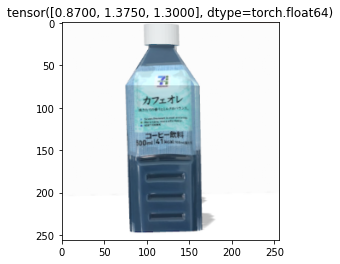

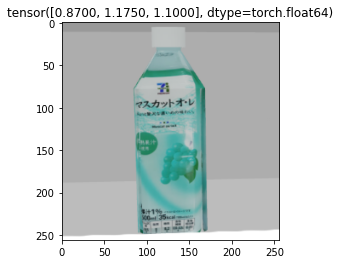

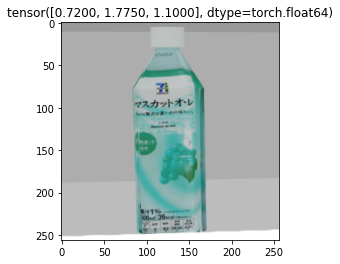

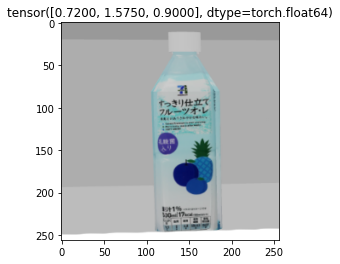

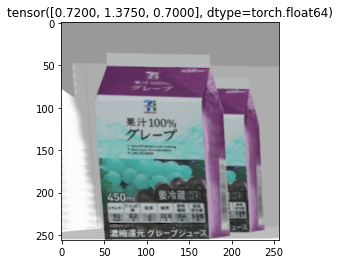

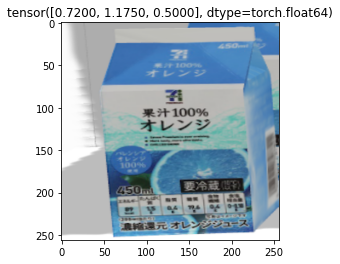

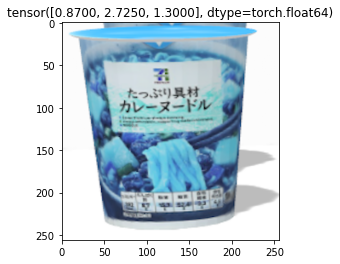

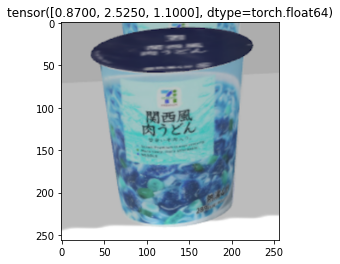

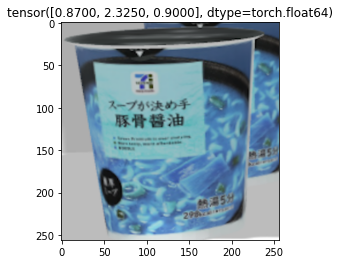

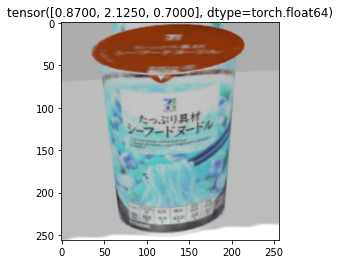

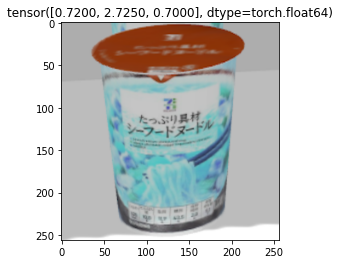

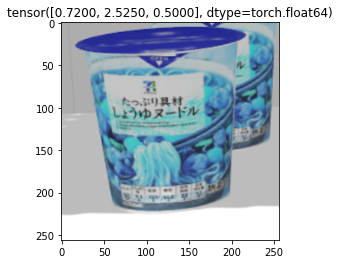

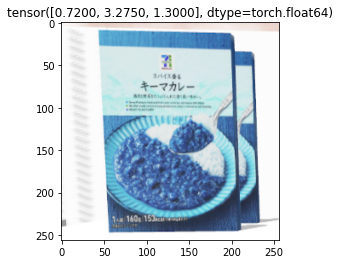

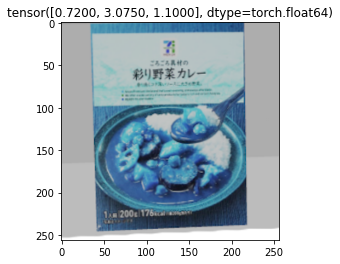

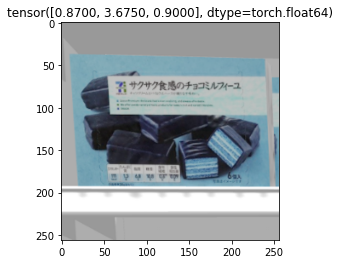

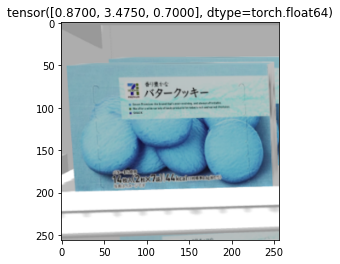

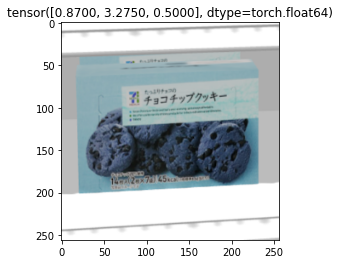

In [11]:
for batch_image, batch_label in train_loader:
    image=batch_image[0,:]
    #print(image.shape)
    label=batch_label[0]
    image=image.numpy()#image=np.array(image)
    image=image.reshape(3,256,256)
    image = image.transpose(1, 2, 0)  # 通道由[c,h,w]->[h,w,c]
    cv_show_image(label,image)

In [12]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm
from pixyz.distributions import Normal, Bernoulli, Categorical
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE
from pixyz.utils import print_latex

In [13]:
x_dim = 256*256*3
y_dim = 3
z_dim = 64


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x","y"], var=["z"], name="q")
        
        self.fc1 = nn.Linear(x_dim+y_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x, y):
#         print(x.shape)
#         print(y.shape)
        h = F.relu(self.fc1(torch.cat([x, y], 1)))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}
    

# inference model q(z|x)
class InferenceX(Normal):
    def __init__(self):
        super(InferenceX, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}


# inference model q(z|y)
class InferenceY(Normal):
    def __init__(self):
        super(InferenceY, self).__init__(cond_var=["y"], var=["z"], name="q")

        self.fc1 = nn.Linear(y_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, y):
        h = F.relu(self.fc1(y))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class GeneratorX(Bernoulli):
    def __init__(self):
        super(GeneratorX, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}


# generative model p(y|z)    
class GeneratorY(Categorical):
    def __init__(self):
        super(GeneratorY, self).__init__(cond_var=["z"], var=["y"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, y_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": F.softmax(self.fc3(h), dim=1)}

    
# prior model p(z)
prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)

p_x = GeneratorX().to(device)
p_y = GeneratorY().to(device)

q = Inference().to(device)
q_x = InferenceX().to(device)
q_y = InferenceY().to(device)

p = p_x * p_y

In [14]:
print(p)
print_latex(p)

Distribution:
  p(x,y|z) = p(x|z)p(y|z)
Network architecture:
  GeneratorY(
    name=p, distribution_name=Categorical,
    var=['y'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=3, bias=True)
  )
  GeneratorX(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=196608, bias=True)
  )


<IPython.core.display.Math object>

In [15]:
kl = KullbackLeibler(q, prior)
kl_x = KullbackLeibler(q, q_x)
kl_y = KullbackLeibler(q, q_y)

regularizer = kl + kl_x + kl_y
print(regularizer)
print_latex(regularizer)

D_{KL} \left[q(z|x,y)||p_{prior}(z) \right] + D_{KL} \left[q(z|x,y)||q(z|x) \right] + D_{KL} \left[q(z|x,y)||q(z|y) \right]


<IPython.core.display.Math object>

In [16]:
model = VAE(q, p, other_distributions=[q_x, q_y],
            regularizer=regularizer, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)
print_latex(model)

Distributions (for training): 
  q(z|x,y), p(x,y|z), q(z|x), q(z|y) 
Loss function: 
  mean \left(D_{KL} \left[q(z|x,y)||p_{prior}(z) \right] + D_{KL} \left[q(z|x,y)||q(z|x) \right] + D_{KL} \left[q(z|x,y)||q(z|y) \right] - \mathbb{E}_{q(z|x,y)} \left[\log p(x,y|z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [17]:
def train(epoch):
    train_loss = 0
    for x, y in tqdm(train_loader):
        #print(x.shape)
        x = x.float().to(device)
        y = y.float().to(device)        
        loss = model.train({"x": x, "y": y})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [18]:
test_loader=train_loader
def test(epoch):
    test_loss = 0
    for x, y in test_loader:
        x = x.float().to(device)
        y = y.float().to(device)
        loss = model.test({"x": x, "y": y})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [ ]:
writer = SummaryWriter()

epochs=10

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      

    
writer.close()

100%|██████████| 17/17 [01:39<00:00,  5.86s/it]


Epoch: 1 Train loss: nan


  0%|          | 0/17 [00:00<?, ?it/s]

Test loss: nan
